In [232]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
import os, sys
import pandas as pd

import matplotlib as mpl

mpl.rcParams.update({"figure.facecolor": "white"})

cwd = os.getcwd()
dirLib = cwd + r'/../library'
if dirLib not in sys.path:
    sys.path.append(dirLib)
    
from load_ARSENL_data import set_binwidth

In [302]:
load_loc = r'C:\Users\Grant\OneDrive - UCB-O365\ARSENL\Experiments\SPCM\evaluation_loss'
fname_pois_fit = r'\eval_loss_dtimeFalse_OD2.0-3.0_order8-17_shots1.00E+05_best_fit.csv'
fname_dead_fit = r'\eval_loss_dtimeTrue_OD2.0-3.0_order8-17_shots1.00E+05_best_fit.csv'

fname_dead = r'\eval_loss_dtimeTrue_OD2.0-3.0_order8-17_shots1.00E+05.csv'

load_ttag_loc = load_loc + r'\fit_figures'
fname_ttag = r'\params_eval_loss_dtimeTrue_OD2.0-3.0_order8-17_ref_shots3.30E+06_lsr_shots1.00E+05_best_fit.pkl'

In [327]:
# Parameters

use_all_OD = True
plot_ref_hist = False
skip_first_num = 6

In [328]:
df_dead_fit = pd.read_csv(load_loc + fname_dead_fit)
df_pois_fit = pd.read_csv(load_loc + fname_pois_fit)

df_dead = pd.read_csv(load_loc + fname_dead)

infile_ttag = open(load_ttag_loc+fname_ttag, 'rb')
load_ttag = pickle.load(infile_ttag)

In [329]:
flight_time_lst = load_ttag[0]
flight_time_ref_lst = load_ttag[1]
t_min = load_ttag[2]
t_max = load_ttag[3]
dt = load_ttag[4]
n_shots = load_ttag[5]
n_shots_ref = load_ttag[6]
active_ratio_hst_lst = load_ttag[7]

In [330]:
C_scale = df_dead['Optimal Scaling Factor']

In [331]:
t_fine = df_dead_fit['time vector']

OD_lst = []
OD_name_lst = []
for column in df_dead_fit:
    if column[:2] == 'OD':    
        OD_lst.append(float(column[2:]))
        OD_name_lst.append(column)
        
OD_lst = OD_lst[skip_first_num:]
OD_name_lst = OD_name_lst[skip_first_num:]
flight_time_lst = flight_time_lst[skip_first_num:]
active_ratio_hst_lst = active_ratio_hst_lst[skip_first_num:]
C_scale = C_scale[skip_first_num:skip_first_num+len(OD_lst)]

print('OD values investigated: {}'.format(OD_lst))

OD values investigated: [2.7, 2.8, 2.9, 3.0]


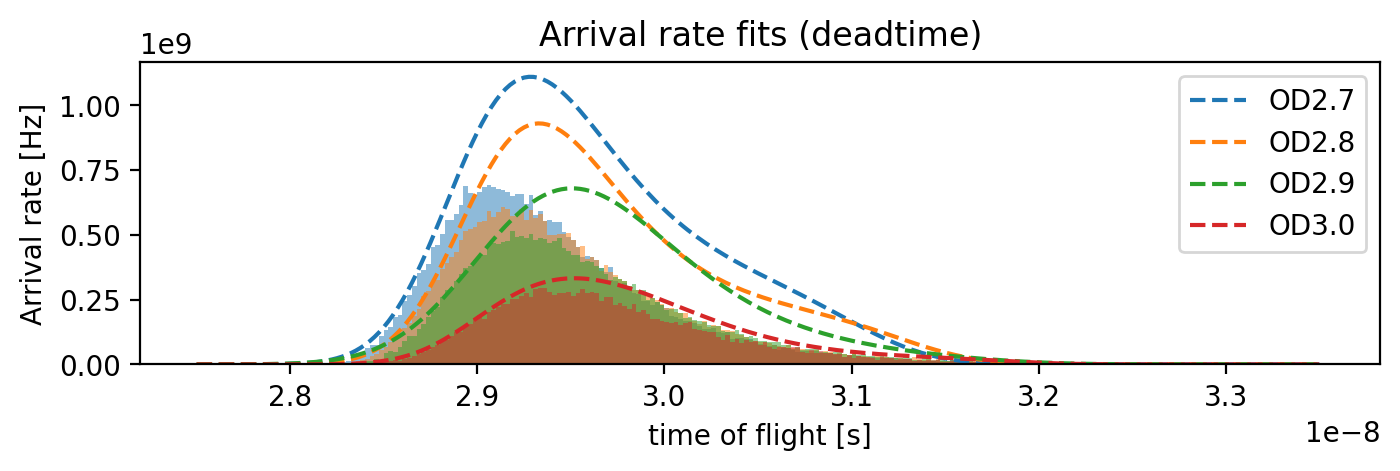

In [332]:
if not use_all_OD:
    OD_val = 3.7

fig = plt.figure(dpi=200, figsize=(8,2))
ax = fig.add_subplot(111)
if use_all_OD:
    for i in range(len(OD_lst)):
        fit_dead = df_dead_fit[OD_name_lst[i]]
        fit_pois = df_pois_fit[OD_name_lst[i]]
        dead_max_idx = np.argmin(abs(np.array(fit_dead)-np.max(fit_dead)))
        pois_max_idx = np.argmin(abs(np.array(fit_pois)-np.max(fit_pois)))
#         ax.plot(t_fine, fit_pois, '-')
        ax.plot(t_fine, fit_dead, '--', label='{}'.format(OD_name_lst[i]))
#         ax.axvline(t_fine[dead_max_idx], color='b', alpha=0.5)
#         ax.axvline(t_fine[pois_max_idx], color='y', alpha=0.5)
        
        if not plot_ref_hist:
            flight_time = flight_time_lst[i]
        else:
            flight_time = flight_time_ref_lst
        bin_array = set_binwidth(t_min, t_max, dt)
        n, bins = np.histogram(flight_time, bins=bin_array)
        binwidth = np.diff(bins)[0]
        if not plot_ref_hist:
            N = n / binwidth / n_shots  # [Hz]
        else:
            N = n / binwidth / n_shots_ref / C_scale[i+skip_first_num]  # [Hz]
        center = 0.5 * (bins[:-1] + bins[1:])
        ax.bar(center, N, align='center', width=binwidth, alpha=0.5)
else:
    try:
        idx = np.where(np.array(OD_lst) == OD_val)[0][0]
    except:
        print('incorrect OD value')
        raise
    fit_dead = df_dead_fit[OD_name_lst[idx]]
    fit_pois = df_pois_fit[OD_name_lst[idx]]
    ax.plot(t_fine, fit_pois, '-', label='{}'.format(OD_name_lst[idx]))
    ax.plot(t_fine, fit_dead, '--', label='{}'.format(OD_name_lst[idx]))
    
    if plot_ref_hist:
        flight_time = flight_time_ref_lst
    else:
        flight_time = flight_time_lst[idx]
    bin_array = set_binwidth(t_min, t_max, dt)
    n, bins = np.histogram(flight_time, bins=bin_array)
    binwidth = np.diff(bins)[0]
    if plot_ref_hist:
        N = n / binwidth / n_shots_ref / C_scale[idx]  # [Hz] scale reference histogram to compare with fit visually
    else:
        N = n / binwidth / n_shots  # [Hz]
    center = 0.5 * (bins[:-1] + bins[1:])
    ax.bar(center, N, align='center', width=binwidth, color='b', alpha=0.35)
    
    fig = plt.figure(dpi=200, figsize=(8,2))
    ax_hst = fig.add_subplot(111)
    ax_hst.plot(active_ratio_hst_lst[idx])
    ax_hst.set_xlabel('time steps')
    ax_hst.set_ylabel('active percentage [%]')
    ax_hst.set_ylim([-0.1, 1.1])
    
ax.set_xlabel('time of flight [s]')
ax.set_ylabel('Arrival rate [Hz]')
ax.set_title('Arrival rate fits (deadtime)')
plt.legend()
plt.show()